In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import SVD, Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Loading the datasets for training and testing
train_movies = pd.read_csv('TrainMovies.csv')
train_ratings = pd.read_csv('TrainRatings.csv')
test_movies = pd.read_csv('TestMovies.csv')
test_ratings = pd.read_csv('TestRatings.csv')

# Merging movie data with ratings for train and test
train_df = pd.merge(train_ratings, train_movies, on='movieId', how='left')
test_df = pd.merge(test_ratings, test_movies, on='movieId', how='left')

# Display first few rows of train and test datasets
print("Training Data:", train_df.head())
print("Testing Data:", test_df.head())

Training Data:    userId  movieId  rating   timestamp  \
0       1       16     4.0  1217897793   
1       1       24     1.5  1217895807   
2       1       32     4.0  1217896246   
3       1       47     4.0  1217896556   
4       1       50     4.0  1217896523   

                                       title                   genres  
0                              Casino (1995)              Crime|Drama  
1                              Powder (1995)             Drama|Sci-Fi  
2  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)  Mystery|Sci-Fi|Thriller  
3                Seven (a.k.a. Se7en) (1995)         Mystery|Thriller  
4                 Usual Suspects, The (1995)   Crime|Mystery|Thriller  
Testing Data:    userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3     

Shape of Training Data: (105339, 6)
Missing values in Training Data:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

Training Data Description:
              userId        movieId         rating     timestamp
count  105339.000000  105339.000000  105339.000000  1.053390e+05
mean      364.924539   13381.312477       3.516850  1.130424e+09
std       197.486905   26170.456869       1.044872  1.802660e+08
min         1.000000       1.000000       0.500000  8.285650e+08
25%       192.000000    1073.000000       3.000000  9.711008e+08
50%       383.000000    2497.000000       3.500000  1.115154e+09
75%       557.000000    5991.000000       4.000000  1.275496e+09
max       668.000000  149532.000000       5.000000  1.452405e+09


C:\Users\anagh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


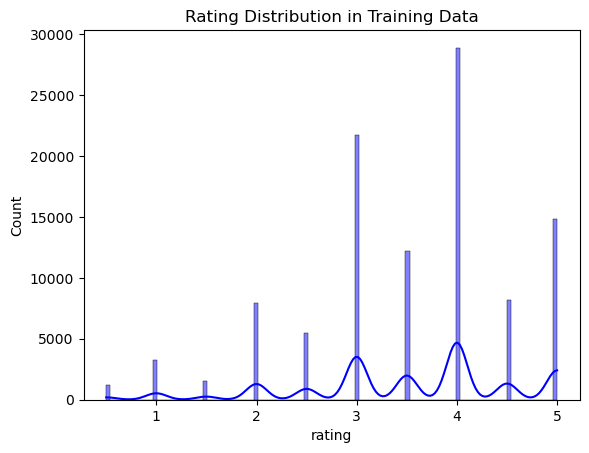

C:\Users\anagh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


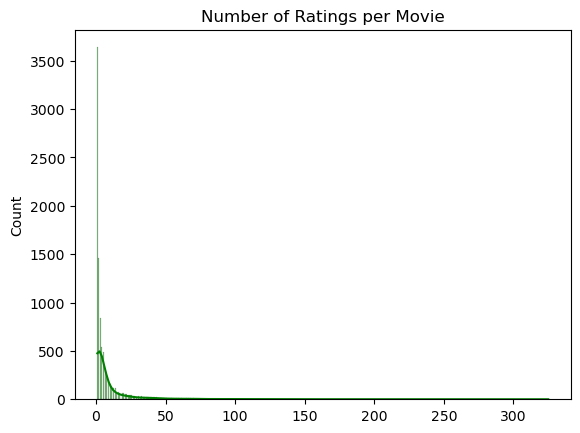

C:\Users\anagh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


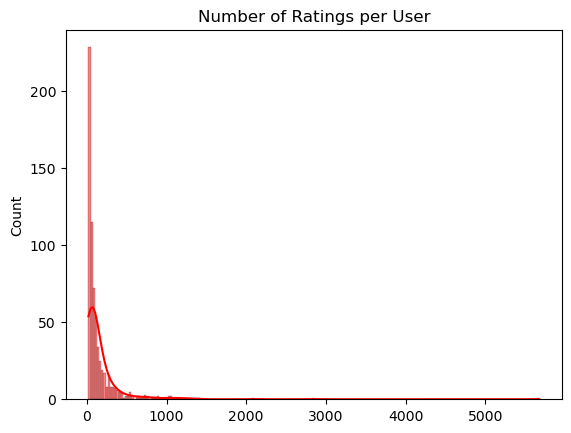

In [3]:
# EDA for the training data
print(f"Shape of Training Data: {train_df.shape}")
print(f"Missing values in Training Data:\n{train_df.isnull().sum()}")

# Basic Statistics
print(f"\nTraining Data Description:\n{train_df.describe()}")

# Distribution of ratings
sns.histplot(train_df['rating'], kde=True, color='blue')
plt.title('Rating Distribution in Training Data')
plt.show()

# Distribution of number of ratings per movie
train_movie_ratings_count = train_df.groupby('movieId').size()
sns.histplot(train_movie_ratings_count, kde=True, color='green')
plt.title('Number of Ratings per Movie')
plt.show()

# Distribution of number of ratings per user
train_user_ratings_count = train_df.groupby('userId').size()
sns.histplot(train_user_ratings_count, kde=True, color='red')
plt.title('Number of Ratings per User')
plt.show()

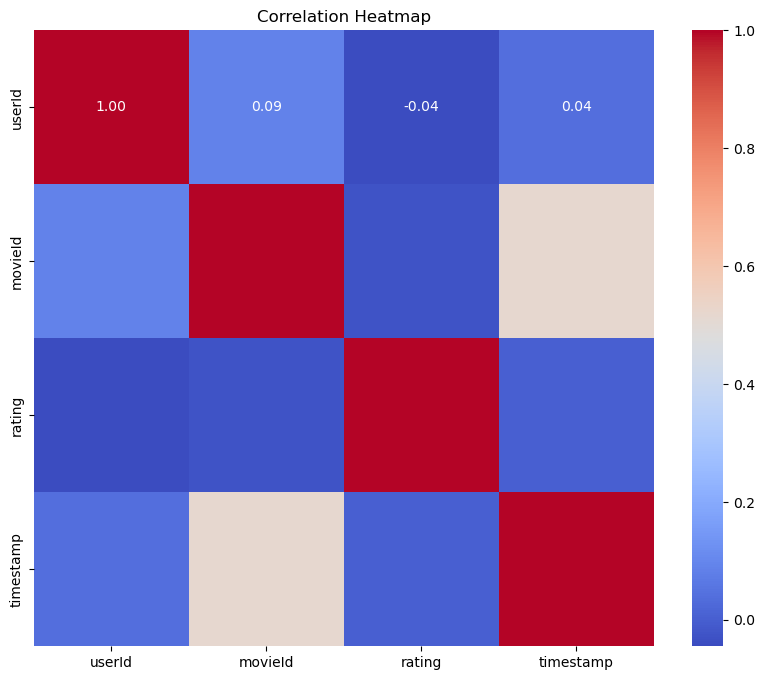

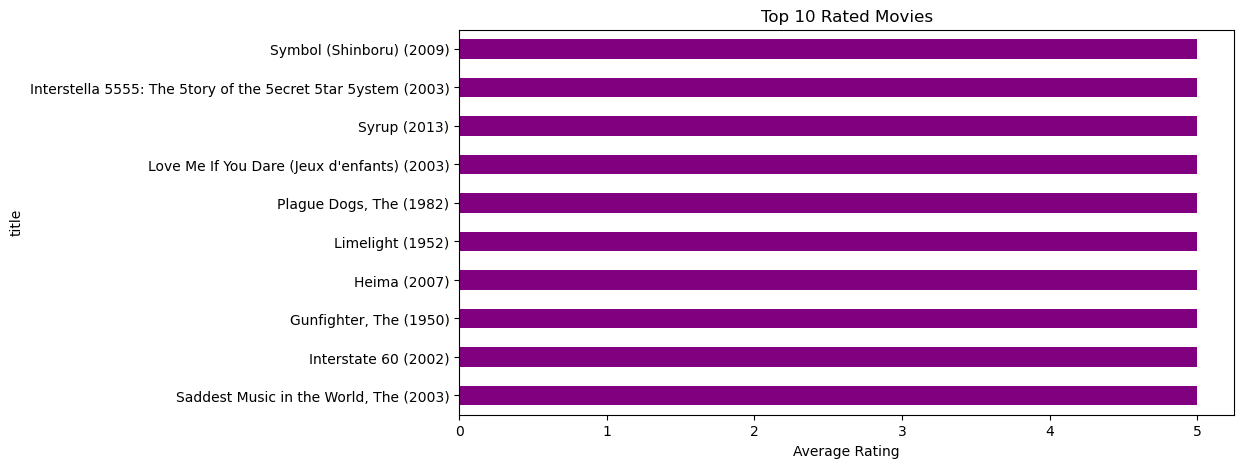

In [4]:
# Select numerical columns for correlation
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Most rated movies in the training set
top_rated_movies = train_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
top_rated_movies.plot(kind='barh', color='purple', figsize=(10, 5))
plt.title('Top 10 Rated Movies')
plt.xlabel('Average Rating')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
import torch

# Split the training dataset into 80% training and 20% validation using sklearn's train_test_split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare data for training
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long)
train_movies = torch.tensor(train_data['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

val_users = torch.tensor(val_data['userId'].values, dtype=torch.long)
val_movies = torch.tensor(val_data['movieId'].values, dtype=torch.long)
val_ratings = torch.tensor(val_data['rating'].values, dtype=torch.float32)

In [6]:
# Train the SVD model using Surprise library
reader = Reader(rating_scale=(1, 5))
train_data_svd = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
trainset_svd = train_data_svd.build_full_trainset()
svd_model = SVD()
svd_model.fit(trainset_svd)

# Evaluate SVD on training data
train_predictions_svd = svd_model.test(trainset_svd.build_testset())
svd_rmse = accuracy.rmse(train_predictions_svd)
svd_mae = accuracy.mae(train_predictions_svd)
print(f"SVD Model - RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")

RMSE: 0.6387
MAE:  0.4974
SVD Model - RMSE: 0.6387, MAE: 0.4974


In [7]:
from surprise import NMF, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define the reader
reader = Reader(rating_scale=(1, 5))

# Load the data from pandas dataframe
train_data_nmf = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

# Build trainset
trainset_nmf = train_data_nmf.build_full_trainset()

# Initialize the NMF model from Surprise
nmf_model = NMF()

# Train the model
nmf_model.fit(trainset_nmf)

# Evaluate the model on the training data
train_predictions_nmf = nmf_model.test(trainset_nmf.build_testset())
nmf_rmse = accuracy.rmse(train_predictions_nmf)
nmf_mae = accuracy.mae(train_predictions_nmf)

# Print the results
print(f"NMF Model - RMSE: {nmf_rmse:.4f}, MAE: {nmf_mae:.4f}")

RMSE: 0.6006
MAE:  0.4364
NMF Model - RMSE: 0.6006, MAE: 0.4364


In [8]:
# Train the KNN model using Surprise library
knn_model = KNNBasic()
knn_model.fit(trainset_svd)

# Evaluate KNN on training data
train_predictions_knn = knn_model.test(trainset_svd.build_testset())
knn_rmse = accuracy.rmse(train_predictions_knn)
knn_mae = accuracy.mae(train_predictions_knn)
print(f"KNN Model - RMSE: {knn_rmse:.4f}, MAE: {knn_mae:.4f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7032
MAE:  0.5286
KNN Model - RMSE: 0.7032, MAE: 0.5286


In [9]:
# Train the NCF model using Surprise library
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Neural Collaborative Filtering (NCF) model definition
class NCFModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc = nn.Sequential(
            nn.Linear(embedding_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        x = torch.cat([user_embed, movie_embed], dim=1)
        return self.fc(x)

# Remap userId and movieId to zero-based indices
train_data['userId'] = train_data['userId'].astype("category").cat.codes
train_data['movieId'] = train_data['movieId'].astype("category").cat.codes

# Convert userId, movieId, and rating to tensors
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long)
train_movies = torch.tensor(train_data['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

# Initialize NCF model
num_users = len(train_data['userId'].unique())
num_movies = len(train_data['movieId'].unique())
ncf_model = NCFModel(num_users, num_movies)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ncf_model.parameters(), lr=0.001)

# RMSE function for evaluation
def compute_rmse(predictions, targets):
    mse = nn.MSELoss()(predictions, targets)
    rmse = torch.sqrt(mse)
    return rmse.item()

# MAE function for evaluation
def compute_mae(predictions, targets):
    mae = nn.L1Loss()(predictions, targets)
    return mae.item()

# Train NCF Model
epochs = 5
for epoch in range(epochs):
    ncf_model.train()
    optimizer.zero_grad()
    outputs = ncf_model(train_users, train_movies).squeeze()
    loss = criterion(outputs, train_ratings)
    loss.backward()
    optimizer.step()
    
    # Evaluate the model using RMSE and MAE
    rmse = compute_rmse(outputs, train_ratings)
    mae = compute_mae(outputs, train_ratings)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, RMSE: {rmse}, MAE: {mae}")

Epoch 1/5, Loss: 9.943455696105957, RMSE: 3.153324604034424, MAE: 2.9753665924072266
Epoch 2/5, Loss: 9.812798500061035, RMSE: 3.1325385570526123, MAE: 2.953763008117676
Epoch 3/5, Loss: 9.681650161743164, RMSE: 3.11153507232666, MAE: 2.9319026470184326
Epoch 4/5, Loss: 9.55018138885498, RMSE: 3.090336799621582, MAE: 2.909803628921509
Epoch 5/5, Loss: 9.418538093566895, RMSE: 3.0689637660980225, MAE: 2.8874895572662354


In [10]:
# Train the TFIDF model using Surprise library
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load Data
train_movies = pd.read_csv('TrainMovies.csv')  # Ensure this file is correctly loaded
print(train_movies.head())  # Check if the data is loaded correctly

# Step 2: Check if 'genres' column exists
if 'genres' not in train_movies.columns:
    raise ValueError("The 'genres' column is missing in the dataset.")
    
# Step 3: Handle missing values in the 'genres' column
train_movies['genres'] = train_movies['genres'].fillna('')  # Handle missing genres if necessary

# Step 4: Normalize movie titles (strip spaces and convert to lowercase)
train_movies['title'] = train_movies['title'].str.strip().str.lower()

# Step 5: Vectorize movie genres using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the 'genres' column to obtain TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(train_movies['genres'])

# Step 6: Compute Cosine Similarity between all movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 7: Function to recommend movies based on cosine similarity
def recommend_movies_based_on_genre(movie_title, cosine_sim=cosine_sim):
    # Normalize the input title (strip spaces and convert to lowercase)
    movie_title = movie_title.strip().lower()
    
    # Step 7.1: Get the index of the movie that matches the title
    idx = train_movies.loc[train_movies['title'] == movie_title].index
    
    if len(idx) == 0:
        raise ValueError(f"Movie title '{movie_title}' not found in the dataset.")
    
    # Get the first index from the matched titles
    idx = idx[0]
    
    # Step 7.2: Get a list of cosine similarity scores for this movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Step 7.3: Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Step 7.4: Get the indices of the top 10 most similar movies
    movie_indices = [i[0] for i in sim_scores[1:11]]  # Exclude the first movie (it will be the movie itself)
    
    # Step 7.5: Return the top 10 most similar movies
    return train_movies['title'].iloc[movie_indices]

# Example: Recommend movies similar to 'The Dark Knight'
recommended_movies = recommend_movies_based_on_genre('Casino (1995)')
print("Recommended Movies based on Genres for 'Casino (1995)':")
print(recommended_movies)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Recommended Movies based on Genres for 'Casino (1995)':
29     shanghai triad (yao a yao yao dao waipo qiao) ...
35                               dead man walking (1995)
89                               hate (haine, la) (1995)
105                young poisoner's handbook, the (1995)
215                              the glass shield (1994)
217                            heavenly creatures (1994)
237    

In [11]:
import pandas as pd
import numpy as np

# Define a threshold for binary classification
threshold = 3.0

# Convert predictions and actual ratings to binary values
def calculate_accuracy(predictions, actual_ratings, threshold=3.0):
    predicted_binary = [1 if pred >= threshold else 0 for pred in predictions]
    actual_binary = [1 if actual >= threshold else 0 for actual in actual_ratings]
    accuracy = np.mean(np.array(predicted_binary) == np.array(actual_binary))
    return accuracy

# Compute accuracy for each model
svd_accuracy = calculate_accuracy([pred.est for pred in train_predictions_svd], 
                                  [pred.r_ui for pred in train_predictions_svd])

nmf_accuracy = calculate_accuracy([pred.est for pred in train_predictions_nmf], 
                                  [pred.r_ui for pred in train_predictions_nmf])

knn_accuracy = calculate_accuracy([pred.est for pred in train_predictions_knn], 
                                   [pred.r_ui for pred in train_predictions_knn])

ncf_accuracy = calculate_accuracy(outputs.detach().numpy(), train_ratings.numpy())

# Store model results
results = {
    'Model': ['SVD', 'NMF', 'KNN', 'NCF'],
    'RMSE': [svd_rmse, nmf_rmse, knn_rmse, rmse],  
    'MAE': [svd_mae, nmf_mae, knn_mae, mae],
    'Accuracy': [svd_accuracy, nmf_accuracy, knn_accuracy, ncf_accuracy]
}

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
  Model      RMSE       MAE  Accuracy
0   SVD  0.638686  0.497389  0.880528
1   NMF  0.600579  0.436357  0.876363
2   KNN  0.703189  0.528606  0.877004
3   NCF  3.068964  2.887490  0.185366


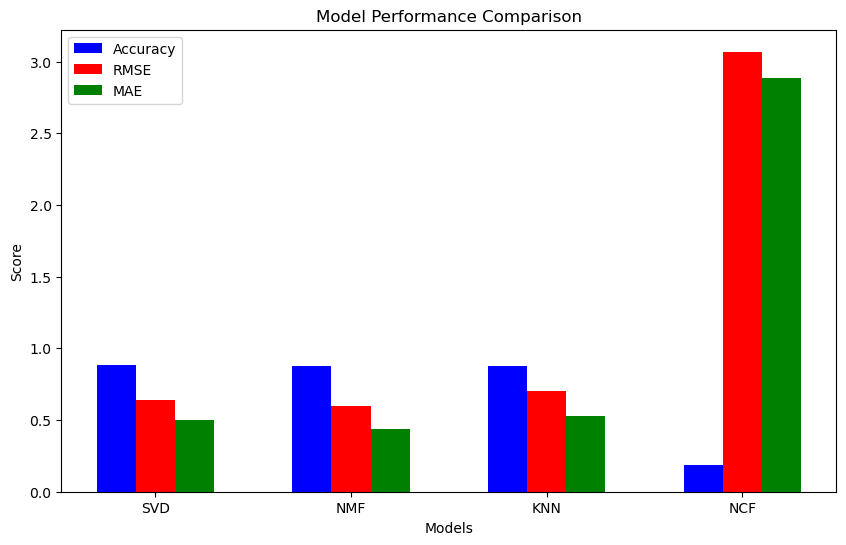

In [12]:
# --- Visualization ---
plt.figure(figsize=(10, 6))

# Plot bar chart
x = np.arange(len(results_df['Model']))  # Model indices
width = 0.2  # Bar width

plt.bar(x - width, results_df['Accuracy'], width=width, label='Accuracy', color='b')
plt.bar(x, results_df['RMSE'], width=width, label='RMSE', color='r')
plt.bar(x + width, results_df['MAE'], width=width, label='MAE', color='g')

# Labels & Title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'])
plt.legend()

# Show plot
plt.show()

In [13]:
#Save Models
import pickle
import torch

# Save SVD Model
with open("Models/svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

# Save NMF Model
with open("Models/nmf_model.pkl", "wb") as f:
    pickle.dump(nmf_model, f)

# Save KNN Model
with open("Models/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)

# Save NCF Model
torch.save(ncf_model.state_dict(), "Models/ncf_model.pth")

# Save the TF-IDF vectorizer
with open("Models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

print("✅ All models trained and saved successfully!")

✅ All models trained and saved successfully!


In [14]:
#Load and Initilaize models
import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define parameters and Load NCF model
# Define the model architecture
class NCFModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc = nn.Sequential(
            nn.Linear(embedding_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        x = torch.cat([user_embed, movie_embed], dim=1)
        return self.fc(x)

# Initialize the model with the number of users and movies
num_users = len(train_data['userId'].unique())
num_movies = len(train_data['movieId'].unique())
ncf_model = NCFModel(num_users, num_movies)

# Load the saved state dictionary
ncf_model.load_state_dict(torch.load('Models/ncf_model.pth'))
ncf_model.eval()  # Set the model to evaluation mode

# Step 2: Load other saved models
with open('Models/svd_model.pkl', 'rb') as f:
    svd_model = pickle.load(f)

with open('Models/nmf_model.pkl', 'rb') as f:
    nmf_model = pickle.load(f)

with open('Models/knn_model.pkl', 'rb') as f:
    knn_model = pickle.load(f)

with open("Models/tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

In [15]:
# EDA for the training data
print(f"Shape of Testing Data: {test_df.shape}")
print(f"Missing values in Testing Data:\n{test_df.isnull().sum()}")

# Get basic stats
print(f"\nTesting Data Description:\n{test_df.describe()}")

# Preprocessing like filling missing values or text normalization
test_df['genres'] = test_df['genres'].fillna('')
test_df['title'] = test_df['title'].str.strip().str.lower()

Shape of Testing Data: (100836, 6)
Missing values in Testing Data:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

Testing Data Description:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [16]:
# Evaluate SVD model
def svd_predict(user_id, movie_id):
    # Make prediction for the given user and movie pair
    return svd_model.predict(user_id, movie_id).est

# Evaluate predictions on test set
svd_predictions = [
    svd_predict(row['userId'], row['movieId']) for _, row in test_df.iterrows()
]

# Calculate RMSE for SVD model
svd_rmse = np.sqrt(mean_squared_error(test_df['rating'], svd_predictions))

# Calculate MAE for SVD model
svd_mae = mean_absolute_error(test_df['rating'], svd_predictions)

# Print RMSE
print(f"SVD Model RMSE: {svd_rmse}")
print(f"SVD Model MAE: {svd_mae}")

SVD Model RMSE: 1.0677596139976229
SVD Model MAE: 0.8329327221899593


In [17]:
# Evaluate NMF model
def nmf_predict(user_id, movie_id):
    # Predict ratings using NMF
    return nmf_model.predict(user_id, movie_id).est

nmf_predictions = [
    nmf_predict(row['userId'], row['movieId']) for _, row in test_df.iterrows()
]

# Calculate RMSE for NMF model
nmf_rmse = np.sqrt(mean_squared_error(test_df['rating'], nmf_predictions))

# Calculate MAE for NMF model
nmf_mae = mean_absolute_error(test_df['rating'], nmf_predictions)

# Print RMSE
print(f"NMF Model RMSE: {nmf_rmse}")
print(f"NMF Model MAE: {nmf_mae}")

NMF Model RMSE: 1.0901463668662101
NMF Model MAE: 0.8525814588537295


In [18]:
# Evaluate KNN model
def knn_predict(user_id, movie_id):
    # Predict ratings using KNN model
    return knn_model.predict(user_id, movie_id).est

# Generate predictions for the test set
knn_predictions = [
    knn_predict(row['userId'], row['movieId']) for _, row in test_df.iterrows()
]

# Calculate RMSE for KNN model
knn_rmse = np.sqrt(mean_squared_error(test_df['rating'], knn_predictions))

# Calculate MAE for KNN model
knn_mae = mean_absolute_error(test_df['rating'], knn_predictions)

# Print RMSE
print(f"KNN Model RMSE: {knn_rmse}")
print(f"KNN Model MAE: {knn_mae}")

KNN Model RMSE: 0.9861127062051429
KNN Model MAE: 0.7593810667873804


In [19]:
# Evaluate NCF model
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to compute RMSE using PyTorch
def compute_rmse(predictions, true_ratings):
    predictions = predictions.float()
    true_ratings = true_ratings.float()
    mse = torch.mean((predictions - true_ratings) ** 2)
    return torch.sqrt(mse)

# Function to compute MAE using PyTorch
def compute_mae(predictions, true_ratings):
    predictions = predictions.float()
    true_ratings = true_ratings.float()
    mae = torch.mean(torch.abs(predictions - true_ratings))
    return mae

# Function to evaluate NCF on unseen data
def evaluate_ncf_model(ncf_model, test_df, user2idx, movie2idx, unknown_user_idx, unknown_movie_idx):
    # Map users and movies to indices, handling unknown users and movies
    test_users = torch.tensor([user2idx.get(user_id, unknown_user_idx) for user_id in test_df['userId']], dtype=torch.long)
    test_movies = torch.tensor([movie2idx.get(movie_id, unknown_movie_idx) for movie_id in test_df['movieId']], dtype=torch.long)
    test_ratings = torch.tensor(test_df['rating'].values, dtype=torch.float32)

    # Set model to evaluation mode
    ncf_model.eval()

    # Perform predictions
    with torch.no_grad():
        predictions = ncf_model(test_users, test_movies).squeeze()

    # Compute evaluation metrics
    rmse = compute_rmse(predictions, test_ratings)
    mae = compute_mae(predictions, test_ratings)

    return rmse, mae, predictions

# Define the NCF Model class
class NCFModel(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(NCFModel, self).__init__()
        self.user_embedding = torch.nn.Embedding(num_users + 1, embedding_size)  # +1 for unknown users
        self.movie_embedding = torch.nn.Embedding(num_movies + 1, embedding_size)  # +1 for unknown movies
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(embedding_size * 2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)  # No sigmoid for correct rating scale
        )

    def forward(self, user, movie):
        user_embed = self.user_embedding(user)
        movie_embed = self.movie_embedding(movie)
        x = torch.cat([user_embed, movie_embed], dim=1)
        return self.fc(x)

# Creating user and movie index mappings
user_ids = train_df['userId'].unique()
movie_ids = train_df['movieId'].unique()

user2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie2idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Assign indices for unknown users and movies
unknown_user_idx = len(user2idx)
unknown_movie_idx = len(movie2idx)

# Get the number of users and movies from the training dataset
num_users = len(user2idx)
num_movies = len(movie2idx)

# Initialize model with correct dimensions
ncf_model = NCFModel(num_users=num_users, num_movies=num_movies)

# Try loading the model while handling embedding size mismatch
try:
    pretrained_dict = torch.load('Models/ncf_model.pth')
    model_dict = ncf_model.state_dict()

    # Filter out mismatched keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}

    # Update the model with matching weights
    model_dict.update(pretrained_dict)
    ncf_model.load_state_dict(model_dict, strict=False)  # Allow missing keys

    print("Model loaded successfully with necessary adjustments.")

except RuntimeError as e:
    print(f"Error loading model: {e}")
    print("Consider retraining the model if mismatches persist.")

# Set model to evaluation mode
ncf_model.eval()

# Evaluate the model on the full test set, including unseen users and movies
ncf_rmse, ncf_mae, ncf_predictions = evaluate_ncf_model(ncf_model, test_df, user2idx, movie2idx, unknown_user_idx, unknown_movie_idx)

# Print the evaluation results
print(f"Test Set RMSE: {ncf_rmse:.4f}")
print(f"Test Set MAE: {ncf_mae:.4f}")

Model loaded successfully with necessary adjustments.
Test Set RMSE: 3.0779
Test Set MAE: 2.8959


In [ ]:
#Accuracy Calculation and Model Comparison
import numpy as np
import pandas as pd

# Define a threshold for binary classification
threshold = 3.0

# Function to calculate accuracy based on a threshold
def calculate_accuracy(predictions, actual_ratings, threshold=3.0):
    predictions = np.array(predictions).flatten()
    actual_ratings = np.array(actual_ratings).flatten()

    if predictions.shape != actual_ratings.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape}, actual {actual_ratings.shape}")

    predicted_binary = (predictions >= threshold).astype(int)
    actual_binary = (actual_ratings >= threshold).astype(int)
    return np.mean(predicted_binary == actual_binary)

# Extract actual ratings from the entire test set (without filtering for known users and movies)
test_ratings = test_df['rating'].to_numpy()

# Compute predictions for SVD, NMF, and KNN on the entire test set using individual user-item pairs
svd_predictions = []
nmf_predictions = []
knn_predictions = []

for idx, row in test_df.iterrows():
    svd_pred = svd_model.predict(row['userId'], row['movieId']).est
    nmf_pred = nmf_model.predict(row['userId'], row['movieId']).est
    knn_pred = knn_model.predict(row['userId'], row['movieId']).est
    
    svd_predictions.append(svd_pred)
    nmf_predictions.append(nmf_pred)
    knn_predictions.append(knn_pred)

# Convert NCF predictions to numpy array
ncf_predictions_np = ncf_predictions.detach().numpy()

if ncf_predictions_np.ndim == 2:
    ncf_predictions_np = ncf_predictions_np.mean(axis=1)

# Compute accuracy for all models on the full test set (unseen data)
svd_test_accuracy = calculate_accuracy(svd_predictions, test_ratings)
nmf_test_accuracy = calculate_accuracy(nmf_predictions, test_ratings)
knn_test_accuracy = calculate_accuracy(knn_predictions, test_ratings)
ncf_test_accuracy = calculate_accuracy(ncf_predictions_np, test_ratings)

# Convert tensors to Python numbers
ncf_rmse = ncf_rmse.item()
ncf_mae = ncf_mae.item()

# Store model results for test data
test_results = {
    'Model': ['SVD', 'NMF', 'KNN', 'NCF'],
    'RMSE': [svd_rmse, nmf_rmse, knn_rmse, ncf_rmse],  
    'MAE': [svd_mae, nmf_mae, knn_mae, ncf_mae],
    'Accuracy': [svd_test_accuracy, nmf_test_accuracy, knn_test_accuracy, ncf_test_accuracy]
}

# Convert results to DataFrame for better visualization
test_results_df = pd.DataFrame(test_results)

# Display the results
print("Fair Model Comparison Results:")
print(test_results_df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualization for Test Data ---
plt.figure(figsize=(10, 6))

# Plot bar chart
x = np.arange(len(test_results_df['Model']))  # Model indices
width = 0.2  # Bar width

plt.bar(x - width, test_results_df['Accuracy'], width=width, label='Accuracy', color='b')
plt.bar(x, test_results_df['RMSE'], width=width, label='RMSE', color='r')
plt.bar(x + width, test_results_df['MAE'], width=width, label='MAE', color='g')

# Labels & Title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Test Model Performance Comparison')
plt.xticks(x, test_results_df['Model'])  # Model names as x-ticks
plt.legend()

# Show plot
plt.show()